## Importing libraries and reading in data:

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df_courses = pd.read_json('./data/processed_data/course_data_clean.json')

### Here's what the data looks like:

In [ ]:
df_courses

### And here's an example of what a review looks like:

In [ ]:
df_courses['reviews'].values[0]

We only need course code, review text, and label (currently called "course_rating_int").

Subsetting to get these columns and dropping rows where the label is missing, we have:

In [ ]:
df_reviews = df_courses[['course_code', 'reviews', 'course_rating_int']].rename(columns={'course_rating_int': 'label'})
df_reviews = df_reviews.loc[df_reviews['label'].notna()]

For preprocessing the label, we could leave it as is (as a binary variable) but instead we're going to create one-hot vectors for each row.

Here is an example of one-hot encoding:

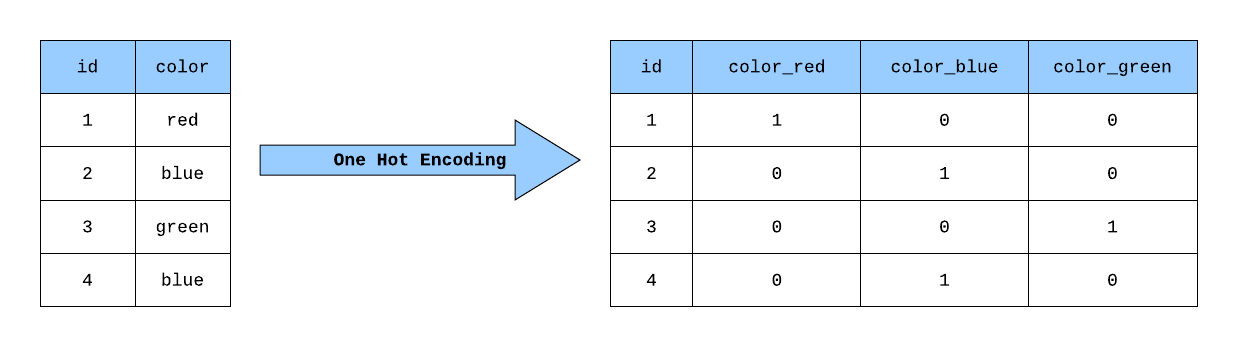

The benefit of doing this is it would be easier to add new labels if we needed. In particular, we could add a third label for "missing rating", if a review did not give a rating.

In [1]:
y = df_reviews['label'].values
oh_y = np.zeros((len(y), 2))
oh_y[np.arange(len(y)), np.array(y).astype(int)] = 1
X_train, X_test, y_train, y_test = train_test_split(list(df_reviews['reviews'].values), oh_y, test_size=0.33, random_state=6)

NameError: name 'df_reviews' is not defined

## HF Trainer

Importing libraries required for HuggingFace Trainer:

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from torch import nn
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

For HuggingFace Trainer, all we need to do is provide the model, training arguments (hyperparameters), metric for scoring, datasets, and finally the tokenizer.

Building the dataset, we have:

In [ ]:
dataset = {
    'train': Dataset.from_dict({'label':y_train,'text':X_train}),
    'test': Dataset.from_dict({'label':y_test,'text':X_test})
}

dataset = DatasetDict(dataset)

Downloading the distillbert tokenizer from the HuggingFace Hub:

*Note that we put it into a function to use "map" to apply it onto the dataset we created above*

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize_text(texts):
    return tokenizer(texts["text"], truncation=True, max_length=512)

In [ ]:
dataset = dataset.map(tokenize_text, batched=True)

We also need to provide the AutoModel (the class that is used to download the model from HuggingFace) a mapping from labels to numbers and numbers to labels.

In [ ]:
id2label = {0: "bad course", 1: "good course"}
label2id = {"bad course": 0, "good course": 1}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

Defining the metric (f1 score) used to score the model:

In [ ]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1": f1}

Setting hyperparameters and creating a TrainingArguments object:

In [ ]:
batch_size = 32
logging_steps = len(X_train) // batch_size
output_dir = "hf_trainer"
training_args = TrainingArguments(
    output_dir=output_dir,
     num_train_epochs=5,
     learning_rate=2e-5,
     per_device_train_batch_size=batch_size,
     per_device_eval_batch_size=batch_size,
     weight_decay=0.01,
     evaluation_strategy="epoch",
     logging_steps=logging_steps,
     p16=True,
     push_to_hub=False
)

Finally we are ready to create our Trainer.

Once we have our trainer, we can call the *train()* method as well as the *evaluate()* method to interact with our model. 

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer
)

Training, evaluating, and saving the model:

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
model_dir = './saved_model/'
trainer.save_model(model_dir + 'distilbert_course_reviews_01')